In [33]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import ShuffleSplit


#  Chapter specifc imports
from pygam import (s as s_gam, f as f_gam, LinearGAM, LogisticGAM, l as l_gam)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)   

#### Question 1


In [34]:
data = load_data("Wage")
data.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


Finished 0 with RSS: 1501086.21
--------------------------------------------------
Finished 1 with RSS: 1433093.91
--------------------------------------------------
Finished 2 with RSS: 1431297.26
--------------------------------------------------
Finished 3 with RSS: 1430614.02
--------------------------------------------------


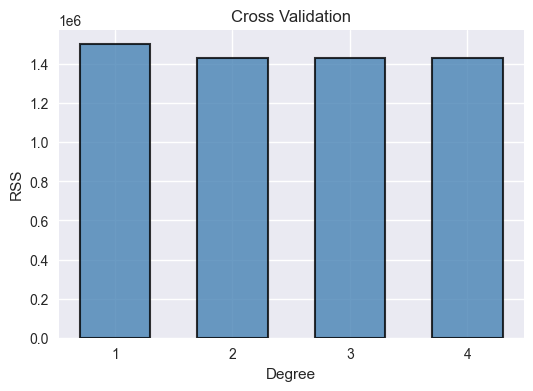

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.602458  2.353254e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.889400  1.678616e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.810061  5.103865e-02


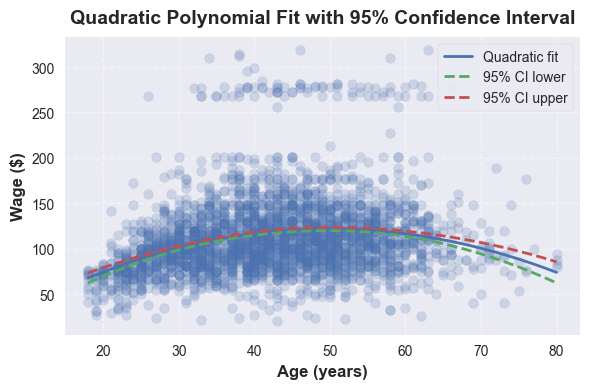

In [126]:
# Age -> Wage -> CrossValidation (d) -> Anova -> Plot

models = [MS([poly("age", degree=i)]).fit(data) for i in range(1, 5)]
x_dat = [m.transform(data) for m in models]

y = data["wage"]

split = 5
cv = ShuffleSplit(n_splits=split, test_size=0.3, random_state=42)
rss_vals = np.array([])

# Cross Validation
for i,x in enumerate(x_dat) : 
    rss = 0
    for train_idx, test_idx in cv.split(x) : 
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model = sm.OLS(y_train, x_train).fit()
        y_pred = model.predict(x_test)
        rss += np.sum((y_test - y_pred) ** 2)
    rss = rss / split
    rss_vals = np.append(rss_vals, rss)
    print(f"Finished {i} with RSS: {rss:.2f}")
    print("-" * 50)
    
# Plotting the Cross Validation
degrees = np.arange(1, 5)
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(degrees, rss_vals, width=0.6, color='steelblue', 
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_xticks(degrees)
ax.set_title("Cross Validation")
ax.set_xlabel("Degree")
ax.set_ylabel("RSS")
plt.show()


# ANOVA
f_test = anova_lm(*[sm.OLS(y,x).fit() for x in x_dat], typ=1)
print(f_test)

# Plotting
age_grid = np.linspace(data['age'].min(), data['age'].max(), 1000)
age = data['age']
y = data['wage']

age_df = pd.DataFrame({'age': age_grid}) # This line was causing the problem
design = MS([poly("age", degree=2)]).fit(data)
x = design.transform(data)
x_new = design.transform(age_df)
model = sm.OLS(y, x).fit()
preds = model.get_prediction(x_new) # This function houses the conf band
bands = preds.conf_int(alpha=0.05)

# Plotting the results
labels = ['Quadratic fit', '95% CI lower', '95% CI upper']
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(age, y, alpha=0.2)
for val, ls, label in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['-', '--', '--'], labels):
    ax.plot(age_grid, val, ls=ls, linewidth=2, label=label)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Age (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Wage ($)', fontsize=12, fontweight='bold')
ax.set_title('Quadratic Polynomial Fit with 95% Confidence Interval', 
             fontsize=14, fontweight='bold', pad=10)
ax.legend(loc='upper right', framealpha=0.9, frameon=True, fontsize=10)
plt.style.use('seaborn-v0_8')
plt.tight_layout()
plt.show()


Best degree that explain is degree `2` as confirmed by both bar chart and anova table. 